In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm



from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)
from pathlib import Path
import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl

from src.config import ExtractConfig
from src.llms.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.llms.phi.model_phi import PhiForCausalLMWHS
from src.eval.ds import filter_ds_to_known
from src.datasets.act_dm import ActivationDataModule

# plt.style.use("ggplot")
# plt.style.use("seaborn-v0_8")
import seaborn as sns
sns.set_theme('paper')


## Paramsnet


In [2]:
# params

# cfg = ExtractConfig(
#     # model="microsoft/phi-2",
#     # # batch_size=1,
#     # prompt_format="phi",
# )
# cfg

# params
batch_size = 32
lr = 1e-3
wd = 0 # 1e-5

MAX_ROWS = 2000

SKIP=5 # skip initial N layers
STRIDE=4 # skip every N layers
DECIMATE=4 # discard N features for speed

device = "cuda:0"
max_epochs = 33

# VAE_EPOCH_MULT = 1
l1_coeff = 1.0e-1  # neel uses 3e-4 ! https://github.dev/neelnanda-io/1L-Sparse-Autoencoder/blob/bcae01328a2f41d24bd4a9160828f2fc22737f75/utils.py#L106, but them they sum l1 where mean l2
    # x_feats=x_feats. other use 1e-1


BASE_FOLDER = Path("/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/")
layers_names = ('fc1', 'Wqkv', 'fc2', 'out_proj')

## Load data

In [3]:
# load hidden state from a previously loaded adapter
# the columns with _base are from the base model, and adapt from adapter
# FROM TRAINING TRUTH
f1_val = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_valtest_*')))
f1_ood = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_OOD_*')))
f1_val, f1_ood

(PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/hidden_states/.ds/ds_valtest_8b8fd6070504d5ef'),
 PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/hidden_states/.ds/ds_OOD_a41d3a61513ade30'))

In [4]:
# insample_datasets = list(set(ds_val['ds_string_base']))
# outsample_datasets = list(set(ds_ood['ds_string_base']))
# print(insample_datasets, outsample_datasets)

In [5]:
input_columns = ['binary_ans_base', 'binary_ans_adapt' ] + [f'end_residual_{layer}_base' for layer in layers_names] + [f'end_residual_{layer}_adapt' for layer in layers_names]

def ds2xy_batched(ds):
    data = []
    for layer in layers_names:
        # Stack the base and adapter representations as a 4th dim
        X1 = [ds[f'end_residual_{layer}_base'], ds[f'end_residual_{layer}_adapt']]
        X1 = rearrange(X1, 'versions b l f  -> b l f versions')
        data.append(X1)
    
    # concat layers
    # x = rearrange(data, 'b parts l f v -> b l (parts f) v')
    X = torch.concat(data, dim=2)[:, SKIP::STRIDE, ::DECIMATE]

    y = ds['binary_ans_base']-ds['binary_ans_adapt']
    return dict(X=X, y=y)



def prepare_ds(ds):
    """
    prepare a dataset for training

    this should front load much of the computation
    it should restrict it to the needed rows X and y
    
    """
    ds = (ds
          .with_format("torch")
          .select_columns(input_columns)
          .map(ds2xy_batched, batched=True, batch_size=128,
        remove_columns=input_columns)
    )
    return ds

def load_file_to_dm(f, stage):
    ds = Dataset.from_file(str(f1_val), in_memory=True).with_format("torch")
    ds = filter_ds_to_known(ds, verbose=True, true_col='truth')
    ds = prepare_ds(ds)

    # limit size
    MAX_SAMPLES = min(len(ds), MAX_ROWS*2)
    ds = ds.select(range(0, MAX_SAMPLES))

    dm = ActivationDataModule(ds, f.stem, batch_size=batch_size, num_workers=0)
    dm.setup(stage)
    return dm


dm = load_file_to_dm(f1_val, 'train')
dm_ood = load_file_to_dm(f1_ood, 'all')

select rows are 74.39% based on knowledge


Map:   0%|          | 0/615 [00:00<?, ? examples/s]

2024-01-07 09:36:32.856 | INFO     | src.datasets.act_dm:setup:64 - converting datasets this may take a while... ds_valtest_8b8fd6070504d5ef train
2024-01-07T09:36:32.856288+0800 INFO converting datasets this may take a while... ds_valtest_8b8fd6070504d5ef train


making shared dataset with unique name ds_valtest_8b8fd6070504d5ef_3f6f12_train
making shared dataset with unique name ds_valtest_8b8fd6070504d5ef_3f6f12_val
making shared dataset with unique name ds_valtest_8b8fd6070504d5ef_3f6f12_test
select rows are 74.39% based on knowledge


Map:   0%|          | 0/615 [00:00<?, ? examples/s]

2024-01-07 09:38:07.354 | INFO     | src.datasets.act_dm:setup:64 - converting datasets this may take a while... ds_OOD_a41d3a61513ade30 all
2024-01-07T09:38:07.354048+0800 INFO converting datasets this may take a while... ds_OOD_a41d3a61513ade30 all


making shared dataset with unique name all


In [6]:
# slow... takes 12 mins. It's the accessing
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
dl_test = dm.test_dataloader()
dl_ood = dm_ood.all_dataloader()

Experiment with dataloading speeds:
- does it help to save the Xy dataset to disc, then load, while keeping in mem?. no not faster at all
- does it help to use num_workers > 0? yes 3x faster
- the shared dataset wrapper is 10x faster, and less mem

# Get importance matrix from adapter

Wqkv torch.Size([32, 7680])
out_proj torch.Size([32, 2560])
fc1 torch.Size([32, 10240])
fc2 torch.Size([32, 2560])


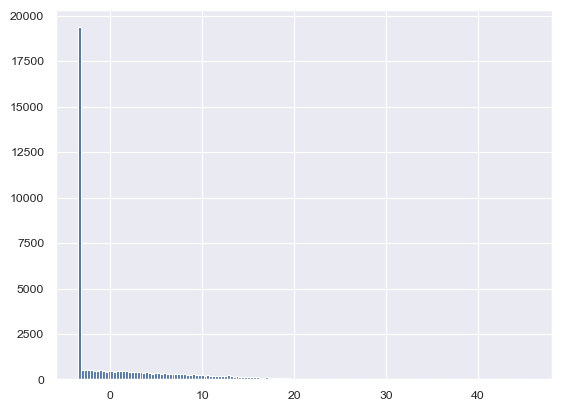

In [7]:
from src.probes.importance_matrix import get_importance_matrix


f = f"{BASE_FOLDER}/checkpoint_last/adapter_model.safetensors"
importance_matrix = get_importance_matrix(f, layers=layers_names)[SKIP::STRIDE, ::DECIMATE]
plt.hist(importance_matrix.flatten(), bins=155);


In [8]:
ds_test2 = dm.datasets['test']
shape1 = ds_test2[0][0][:, :, 0].shape
shape2= importance_matrix.shape
np.testing.assert_equal(shape1, shape2, err_msg="shape mismatch between ds and importance matrix")


# Model

In [9]:

from src.vae.conv_inception import AutoEncoder, PLAE

# Train

### Metrics


In [10]:
def get_acc_subset(df, query, verbose=True):
    if query:
        df = df.query(query)
    acc = (df["probe_pred"] == df["y"]).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc


def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits["test"]
    df_test = dm.df.iloc[splits[0] : splits[1]].copy()
    df_test["probe_pred"] = y_test_pred > 0.0

    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits["val"]
        df_val = dm.df.iloc[splits[0] : splits[1]].copy()
        df_val["probe_pred"] = y_val_pred > 0.0

        df_test = pd.concat([df_val, df_test])

    if verbose:
        print("probe results on subsets of the data")
    acc = get_acc_subset(df_test, "", verbose=verbose)
    get_acc_subset(
        df_test, "instructed_to_lie==True", verbose=verbose
    )  # it was ph told to lie
    get_acc_subset(
        df_test, "instructed_to_lie==False", verbose=verbose
    )  # it was told not to lie
    get_acc_subset(
        df_test, "llm_ans==label_true", verbose=verbose
    )  # the llm gave the true ans
    get_acc_subset(
        df_test, "llm_ans==label_instructed", verbose=verbose
    )  # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=verbose
    )  # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=verbose
    )

    a = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans==label_instructed", verbose=False
    )
    b = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans!=label_instructed", verbose=False
    )
    c = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=False
    )
    d = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=False
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["instructed_to_lie==False", "instructed_to_lie==True"],
        columns=["llm_ans==label_instructed", "llm_ans!=label_instructed"],
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["tell a truth", "tell a lie"],
        columns=["did", "didn't"],
    )
    d1.index.name = "instructed to"
    d1.columns.name = "llm gave"
    print("probe accuracy for quadrants")
    display(d1.round(2))

    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)

### Setup

In [11]:


print(len(dl_train), len(dl_val))
b = next(iter(dl_train))
x, y = b # b['X'], b['y']
print(x.shape, "x")
if x.ndim == 3:
    x = x.unsqueeze(-1)
c_in = x.shape[1:-1]


10 5
torch.Size([32, 7, 5760, 2]) x


In [12]:
# # TEST
# for b in tqdm(dl_train):
#     pass

In [29]:
# %%time
# # oh no, this is very slow
# g = iter(dl_train)
# b = next(g)
# b = next(g)


330

In [14]:

net = PLAE(
    c_in=c_in,
    steps_per_epoch=len(dl_train),
    max_epochs=max_epochs,
    lr=lr,
    weight_decay=wd,
    hs=64,
    depth=3,
    dropout=0,
    n_latent=16,
    l1_coeff=l1_coeff, 
    importance_matrix=importance_matrix,
)
print(c_in)
x1= x[..., 0]
with torch.no_grad():
    y = net(x1)
{k: v.abs().mean() for k, v in y.items()}

torch.Size([7, 5760])


{'pred': tensor(0.1017),
 'l1_loss': tensor(89.3760),
 'l2_loss': tensor(3815.6162),
 'loss': tensor(3815.6162),
 'latent': tensor(0.7980),
 'h_rec': tensor(0.3852)}

In [15]:
from torchinfo import summary

summary(net, input_data=x1, depth=4)  # input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                                  Output Shape              Param #
PLAE                                                    [32, 5760, 7]             --
├─AutoEncoder: 1-1                                      [32]                      --
│    └─InceptionEncoder: 2-1                            [32, 16, 7]               --
│    │    └─Sequential: 3-1                             [32, 256, 7]              --
│    │    │    └─BatchNorm1d: 4-1                       [32, 5760, 7]             --
│    │    │    └─InceptionBlock: 4-2                    [32, 256, 7]              800,960
│    │    │    └─InceptionBlock: 4-3                    [32, 256, 7]              96,448
│    │    │    └─InceptionBlock: 4-4                    [32, 256, 7]              96,448
│    │    │    └─InceptionBlock: 4-5                    [32, 256, 7]              96,448
│    │    │    └─InceptionBlock: 4-6                    [32, 256, 7]              96,448
│    │    └─Sequential: 3-2            

### Train autoencoder

In [16]:
torch.set_float32_matmul_precision('medium')

In [17]:
%%time
for b in tqdm(dl_train):
    pass

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 67.3 ms, sys: 460 ms, total: 527 ms
Wall time: 631 ms


In [18]:
# torch.isfinite(x).all()

In [34]:
for b in tqdm(dl_val):
    x,y=b
    # o = net.validation_step(b, 0)
    x = x[..., 0]
    x = rearrange(x, "b l h -> b h l")
    o = net.ae(x)
# o

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
# s = net.configure_optimizers()[1][0]
# s.total_steps, max_epochs*len(dl_train), 
# df_hist_step['step']

In [20]:
from src.helpers.lightning import read_metrics_csv, plot_hist, rename_pl_test_results

from lightning.pytorch.callbacks import LearningRateMonitor

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


training ae
requires_grad: True


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 2.3 M 
1 | head | Sequential  | 16.1 K
-------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.107     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=33` reached.


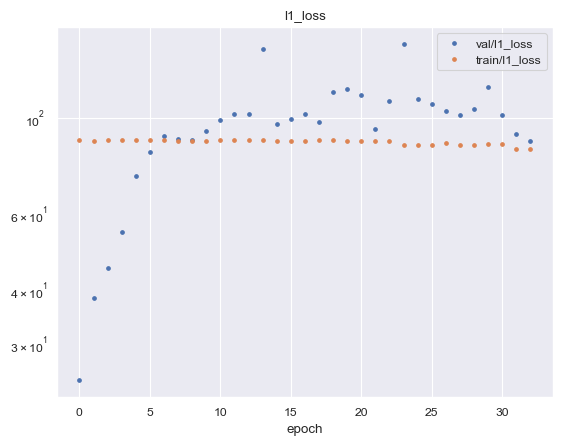

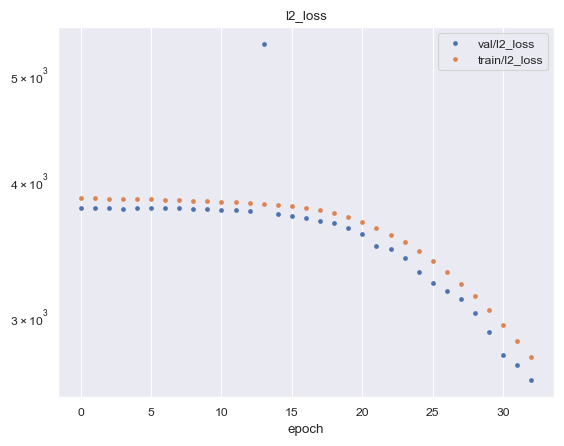

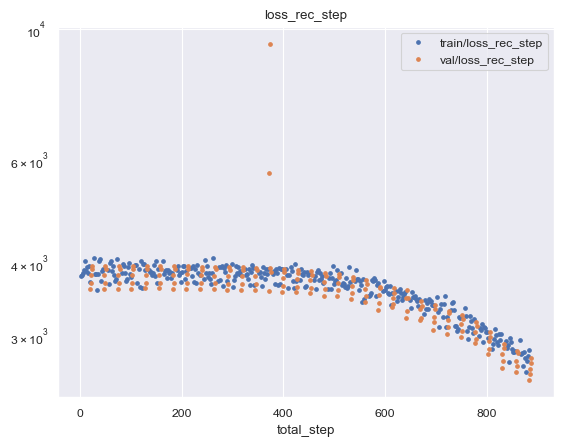

,step,train/loss_pred_step,train/loss_rec_step,lr-AdamW,val/loss_pred_step,val/loss_rec_step,val/loss_pred_epoch,val/n,val/l1_loss,val/auroc,val/loss_rec_epoch,val/acc,val/l2_loss,train/loss_pred_epoch,train/n,train/auroc,train/l2_loss,train/l1_loss,train/acc,train/loss_rec_epoch
epoch,,,,,,,,,,,,,,,,,,,,
0.0,10,0.692269,3690.424072,0.000040,0.686402,3885.482178,0.692814,154.0,24.648914,0.500000,3775.812988,0.512987,3775.812988,0.684216,307.0,0.451129,3857.731689,88.964050,0.615635,3857.731689
1.0,20,0.679082,3895.515137,0.000041,0.685572,3885.197754,0.692752,154.0,38.249973,0.546315,3775.548584,0.512987,3775.548584,0.683068,307.0,0.496639,3856.156006,88.609650,0.615635,3856.156006
2.0,30,0.677388,4048.968750,0.000042,0.685817,3884.292236,0.693103,154.0,44.928791,0.440849,3774.682617,0.512987,3774.682617,0.681573,307.0,0.550721,3853.965332,88.851471,0.615635,3853.965332
3.0,40,0.683169,3766.706787,0.000044,0.681326,3882.894775,0.691818,154.0,54.481380,0.569125,3773.575439,0.512987,3773.575439,0.682679,307.0,0.548141,3851.809082,89.118011,0.612378,3851.809082
4.0,50,0.668281,3867.140625,0.000046,0.680779,3883.655762,0.694193,154.0,73.214371,0.428654,3774.517822,0.512987,3774.517822,0.683727,307.0,0.499266,3848.771484,89.080498,0.612378,3848.771484
5.0,60,0.671579,3889.317383,0.000049,0.678113,3883.855225,0.695022,154.0,83.378967,0.444830,3776.937500,0.512987,3776.937500,0.684422,307.0,0.488261,3847.021973,88.930321,0.615635,3847.021973
6.0,70,0.701464,3830.851074,0.000052,0.681707,3890.009766,0.695543,154.0,91.080406,0.424767,3775.809570,0.512987,3775.809570,0.683623,307.0,0.496281,3844.007812,89.020317,0.615635,3844.007812
7.0,80,0.692646,3851.315430,0.000056,0.681000,3883.450195,0.693881,154.0,89.614014,0.484804,3777.281250,0.512987,3777.281250,0.684258,307.0,0.481628,3841.065186,88.697899,0.615635,3841.065186
8.0,90,0.675808,3800.676758,0.000060,0.688109,3878.761230,0.697340,154.0,88.737358,0.356765,3768.541504,0.512987,3768.541504,0.685532,307.0,0.413805,3837.533447,88.427597,0.615635,3837.533447


In [21]:
net.ae_mode(0)
 
lr_logger = LearningRateMonitor(logging_interval='step')
trainer1 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    # devices=2,
    accelerator="auto",
    devices="1",
    max_epochs=max_epochs,# * VAE_EPOCH_MULT,
    log_every_n_steps=1,
    # enable_progress_bar=False, enable_model_summary=False
    callbacks=[lr_logger],
)

# LOAD_CHECKPONT = Path('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')
LOAD_CHECKPONT = None
if LOAD_CHECKPONT:
    PLAE.load_from_checkpoint(LOAD_CHECKPONT)
else:
    trainer1.fit(model=net, train_dataloaders=dl_train, 
                 val_dataloaders=dl_val # FIXME why does this slow it down with multiple processes?
                )

    df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
    plot_hist(df_hist, ['l2_loss', 'l1_loss', 'loss_rec'], logy=True)
    plt.show()
    plot_hist(df_hist_step, ['loss_rec_step'], logy=True)

    display(df_hist)


<Axes: xlabel='epoch'>

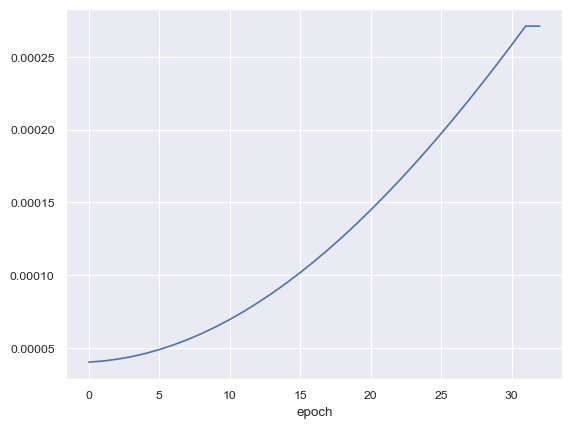

In [22]:
# Check the LR
df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
df_hist['lr-AdamW'].plot()

In [23]:
# s = net.configure_optimizers()[1][0]
# total_steps = net.hparams.steps_per_epoch * net.hparams.max_epochs
# data = []
# for i in range(total_steps):
#     s.step()
#     l_rate = s.get_last_lr()[0]
#     data.append(l_rate)
#     # if i % 100 == 0:
#     #     print(l_rate)

# pd.Series(data).plot()

5/10 [00:04<00:04, 1.10it/s, v_num=295, val/loss_pred=0.0849, val/loss_rec=9.58e+5, train/loss_pred=0.350, train/loss_rec=9.8e+5]


In [24]:
# visualize latent space
from matplotlib import cm


def plot_latent(latent):

    # plot image of latent space
    vmax = latent.abs().max()
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        vmax = latent[i].abs().max()
        plt.imshow(
            latent[i],
            cmap=cm.coolwarm,
            interpolation="none",
            aspect="auto",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xlabel("layer")
        plt.ylabel("neuron")
        if i < 2:
            plt.xlabel("")
            plt.xticks([])
        if i % 2 == 1:
            plt.ylabel("")
            plt.yticks([])
        plt.grid(False)
        plt.colorbar()
    # plt.colorbar()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

    # histogram
    latentf = rearrange(latent, "b n l -> (b n) l").flatten()
    vmax = (latentf.abs().mean() + 5 * latentf.abs().std()).item()
    plt.hist(latentf, bins=55, range=[-vmax, vmax], histtype="step")
    plt.title("latents by layer")
    plt.show()


latent = y["latent"].cpu()  # .reshape(64, 24, 12) # [Batch, Latent, Layer]
plot_latent(latent)


IndexError: too many indices for tensor of dimension 1

In [ ]:
latent.shape, latent.diff(dim=1).std(), latent.std(), latent.diff(dim=2).std(), 16*7

### Train probe

In [ ]:
# # net.save_checkpoint
# f = Path(trainer1.log_dir)/"1_ae.ckpt"
# trainer1.save_checkpoint(f)
# # PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')
# f

In [ ]:
# net.configure_optimizers()

In [ ]:
# debug
with torch.no_grad():
    b = next(iter(dl_train))
    y = net.predict_step(b)

In [ ]:
net.ae_mode(1)
trainer2 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
    callbacks=[lr_logger],
)
trainer2.fit(model=net, train_dataloaders=dl_train, 
            #  val_dataloaders=dl_val
             );


In [ ]:
df_hist, _ = read_metrics_csv(trainer2.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred_epoch', 'auroc'])
df_hist

In [ ]:

# predict


# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer2.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood])




In [ ]:
testval_metrics = calc_metrics(dm, trainer2, net, use_val=True)
rs = rename_pl_test_results(rs, ["train", "val", "test", "ood"])
# rs['test'] = {**rs['test'], **test_metrics}
rs["test"]["acc_lie_lie"] = testval_metrics["acc_lie_lie"]
rs["testval_metrics"] = rs["test"]

#### how well does it generalize to other datasets?


In [ ]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer1.test(net, dataloaders=[dl_ood])
rs2 = rename_pl_test_results(rs2, ks=["ood"])

testval_metrics2 = calc_metrics(dm_ood, trainer1, net, use_val=True)
rs["ood"]["acc_lie_lie"] = testval_metrics2["acc_lie_lie"]
rs["ood_metrics"] = rs2["ood"]
rs


### Train end-to-end


In [ ]:
net.ae_mode(2)
trainer3 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer3.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
1


In [ ]:
# look at hist
df_hist, _ = read_metrics_csv(trainer3.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred', 'acc'])

# predict
# dl_test = dm.test_dataloader()
# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer3.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood])

testval_metrics = calc_metrics(dm, trainer3, net, use_val=True)
rs = rename_pl_test_results(rs, ["train", "val", "test", "ood"])
# rs['test'] = {**rs['test'], **test_metrics}
rs["test"]["acc_lie_lie"] = testval_metrics["acc_lie_lie"]
rs["testval_metrics"] = rs["test"]


In [ ]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer3.test(net, dataloaders=[dl_ood])
rs2 = rename_pl_test_results(rs2, ks=["ood"])

testval_metrics2 = calc_metrics(dm_ood, trainer3, net, use_val=True)
rs["ood"]["acc_lie_lie"] = testval_metrics2["acc_lie_lie"]
rs["ood_metrics"] = rs2["ood"]
rs
